
## Data Preparation

#### Imports and Zip

In [1]:
from zipfile import ZipFile
import cv2
from pathlib import Path
import numpy as np
import os
from datetime import datetime
import io
import imageio
from ipywidgets import widgets, HBox
import matplotlib.pyplot as plt


In [2]:
def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}

zip_path = Path(r'C:\Users\Omar\Documents\ShadowMitigation\SKIPPD\CloudMask_2024.zip')
dara = extract_zip(zip_path)

#### Conversion of Image Bytes to np.array

In [3]:
def convert_bytes(img_bytes):
  return  cv2.imdecode(np.frombuffer(img_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

#### Dataset Preparation and filtering

In [4]:
dataset = {}
for file_name, img_bytes in dara.items():

    x = Path(file_name).stem
    year, month, day, hour, minute = x[:4], x[4:6], x[6:8],x[8:10],x[10:12]

    key = f'{year}-{month}-{day}-{hour}'
    if key not in dataset.keys():
        dataset[key] = []

    dataset[key].append(file_name)

for key, value in dataset.items():
    dataset[key] = sorted(value)

for key, value in dataset.items():
  dataset[key] = [cv2.cvtColor(convert_bytes(dara[v]),cv2.COLOR_BGR2GRAY) for v in value]


faulty = []
correct = []
for k, v in dataset.items():
    if len(v) != 60:
        faulty.append(v)
    else:
        correct.append(v)


### Visualize Random Input Tensors

In [6]:
for i in range(5):
  rng = np.random.randint(0,len(correct)-1)
  v = correct[rng]
  input = np.array([img for img in v])[None, ...]
  print(input.shape,rng)
  for video in input[:32]:          # Loop over videos
      with io.BytesIO() as gif:
          imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
          display(HBox([widgets.Image(value=gif.getvalue())]))


(1, 60, 64, 64) 0


(1, 60, 64, 64) 8


(1, 60, 64, 64) 2


(1, 60, 64, 64) 62


(1, 60, 64, 64) 17


## Create Dataset Class

In [7]:
import torch
from torch.utils.data import Dataset

In [8]:
class MyCloudDataset(Dataset):

    def __init__(self, X):
          super(MyCloudDataset, self).__init__()
          self.X = np.array(X)

          self.mean = None
          self.std = None
          self.data_name = 'CLOUDS'
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        rand = np.random.randint(15, 45)
        data= self.X[index][rand-15:rand, :, :].transpose(0,3,1,2)
        labels = self.X[index][rand:rand+15, :, :].transpose(0,3,1,2)
        data = torch.tensor(data).float()
        labels = torch.tensor(labels).float()
        return data, labels

In [17]:
SKIPPD = np.array(correct, dtype=np.float32) / 255
SKIPPD = SKIPPD[:,:,:,:,None]
SKIPPD.shape

(94, 60, 64, 64, 1)

In [18]:
# Assuming SKIPPD_SHORT is your numpy array with shape (1251, 60, 64, 64, 3)
# Calculate the sum for each sequence over all its frames, pixels, and channels
sequence_sums = np.sum(SKIPPD, axis=(1, 2, 3, 4))

# Filter sequences where the sum is above 100
# This will create a boolean mask where True represents sequences to keep
sequences_to_keep = sequence_sums > np.mean(sequence_sums)
print(np.mean(sequence_sums))

# Apply the mask to filter the sequences
filtered_sequences = SKIPPD[sequences_to_keep]

# Print the shape of the filtered_sequences array to verify the filtering
print(filtered_sequences.shape)

68746.65
(39, 60, 64, 64, 1)


In [19]:
  # Ensures the result is float32
SKIPPD_SHORT =   filtered_sequences
np.random.shuffle(SKIPPD_SHORT)  # Shuffles in-place

# Train, Test, Validation splits
train_split = int(0.7 * len(SKIPPD_SHORT))
val_split = int(0.9 * len(SKIPPD_SHORT))

X_train = SKIPPD_SHORT[:train_split]
X_val = SKIPPD_SHORT[train_split:val_split]
X_test = SKIPPD_SHORT[val_split:]
X_train.shape,X_val.shape, X_test.shape

((27, 60, 64, 64, 1), (8, 60, 64, 64, 1), (4, 60, 64, 64, 1))

In [20]:
train_set = MyCloudDataset(X=X_train)
val_set = MyCloudDataset(X=X_val)
test_set = MyCloudDataset(X=X_test)

In [22]:
print(test_set.__getitem__(0))
print(train_set.__getitem__(0))

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [23]:
batch_size = 10

dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

In [28]:
custom_training_config = {
    'pre_seq_length': 15,
    'aft_seq_length': 15,
    'total_length': 15 + 15,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 20,
    'lr': 0.001,
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [15,1,64,64],
}


custom_model_config = {
    # For MetaVP models, the most important hyperparameters are:
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters
    # 'config_file': 'configs/custom/example_model.py',

    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

In [29]:
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update default parameters
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)

In [31]:
from openstl.methods import SimVP

PATH = r'C:\Users\Omar\Documents\ShadowMitigation\playground\content\checkpoints\best-epoch=28-val_loss=0.018.ckpt'

model = SimVP(steps_per_epoch=1, 
            test_mean=1, 
            test_std=1, 
            save_dir="", 
            **config)

# Load the checkpoint
checkpoint = torch.load(PATH)  # Ensure it's on the right device

# Load the adjusted state_dict into the model
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [45]:
batch = next(iter(dataloader_train))
images_p = model(batch[0])
images_t = batch[1]

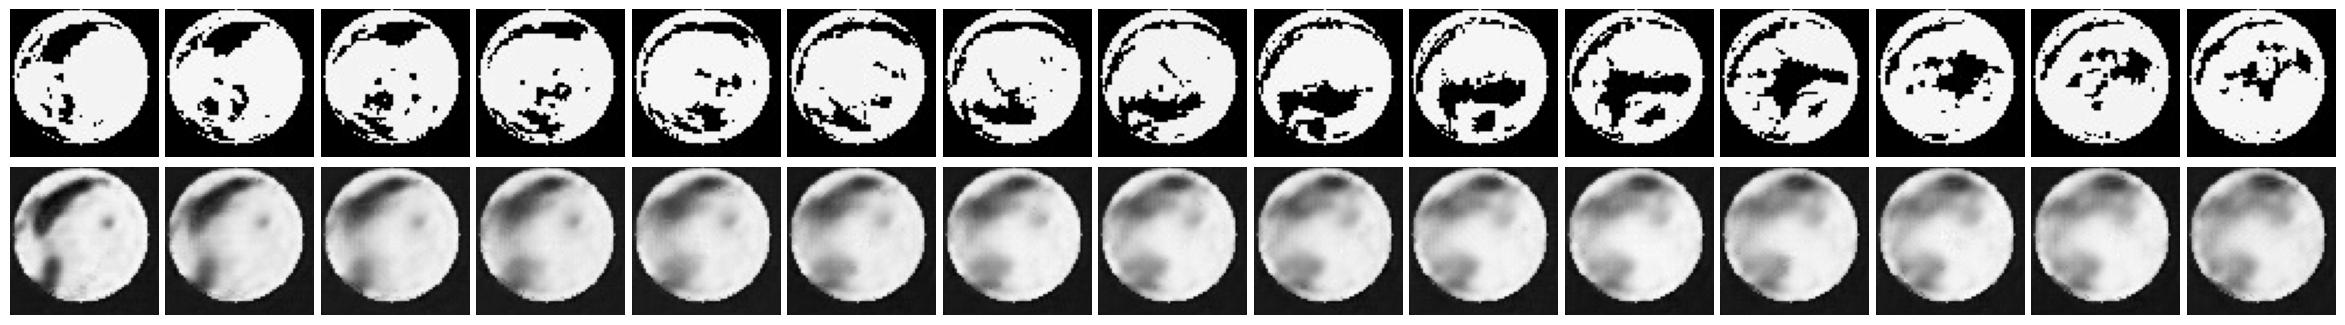

torch.Size([15, 1, 64, 64])


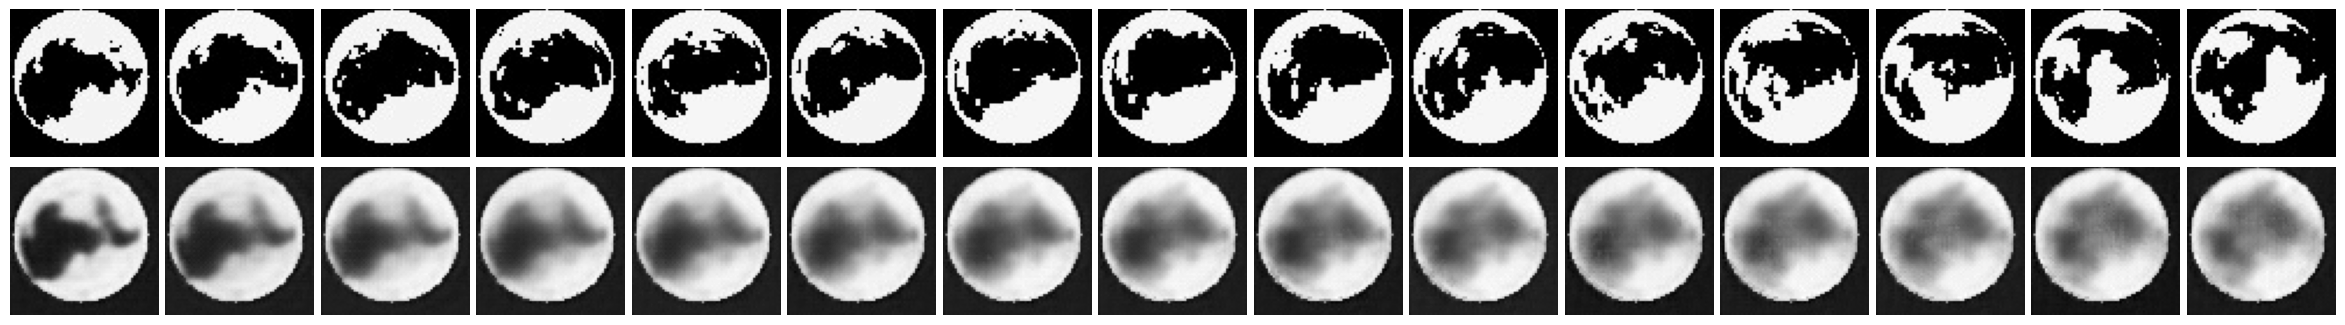

torch.Size([15, 1, 64, 64])


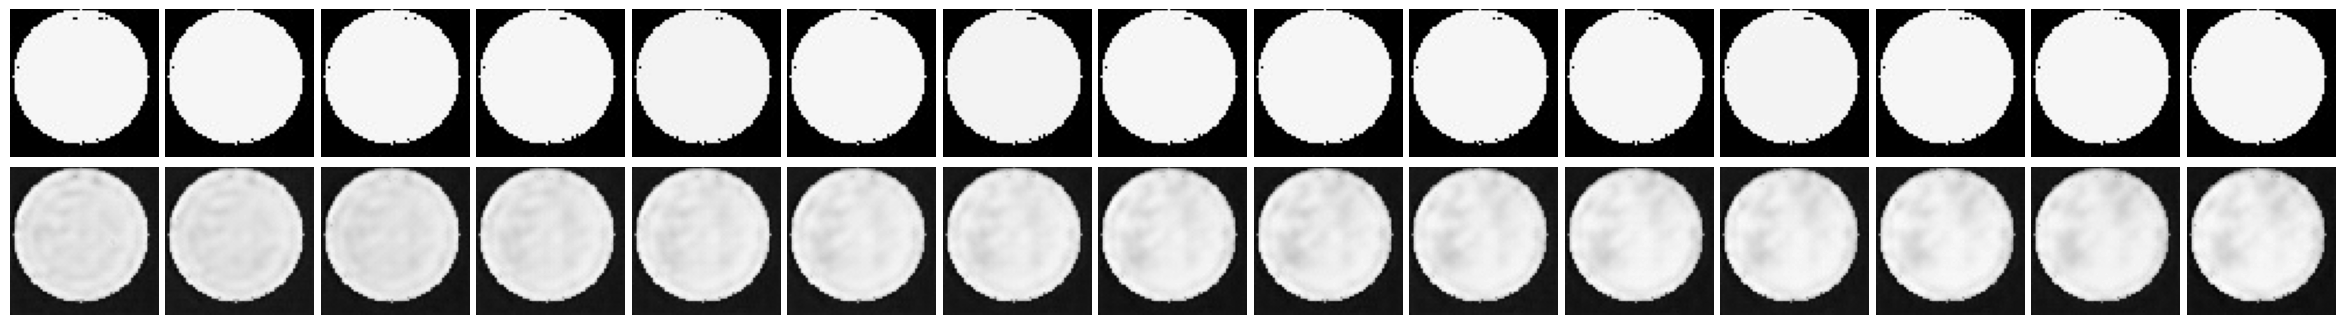

torch.Size([15, 1, 64, 64])


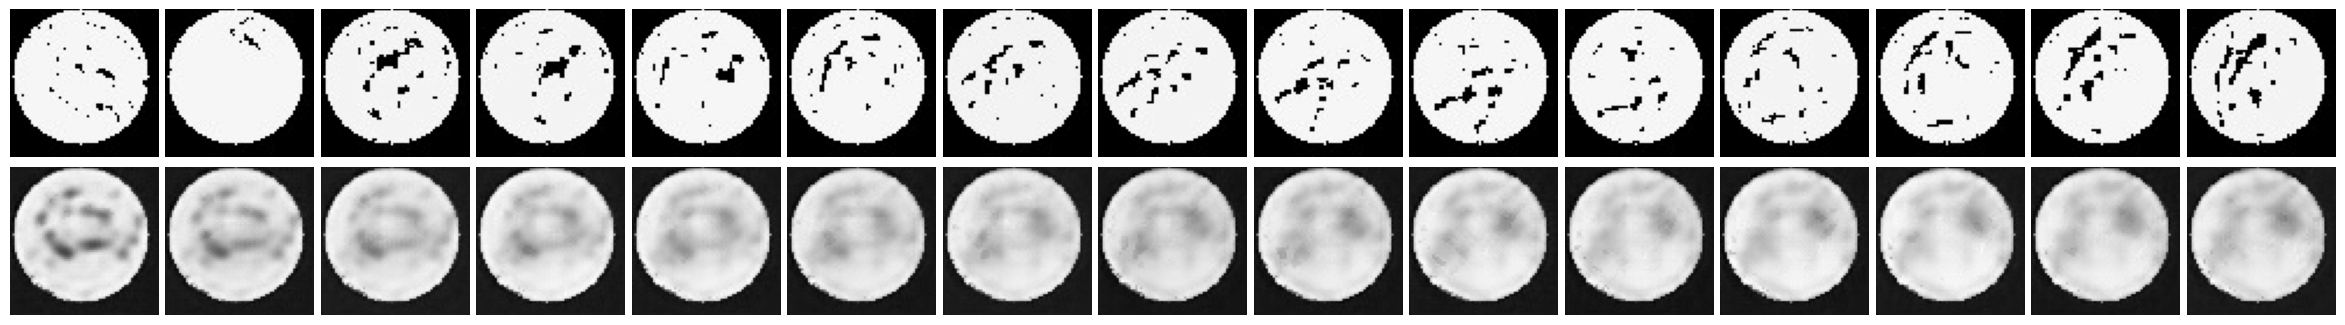

torch.Size([15, 1, 64, 64])


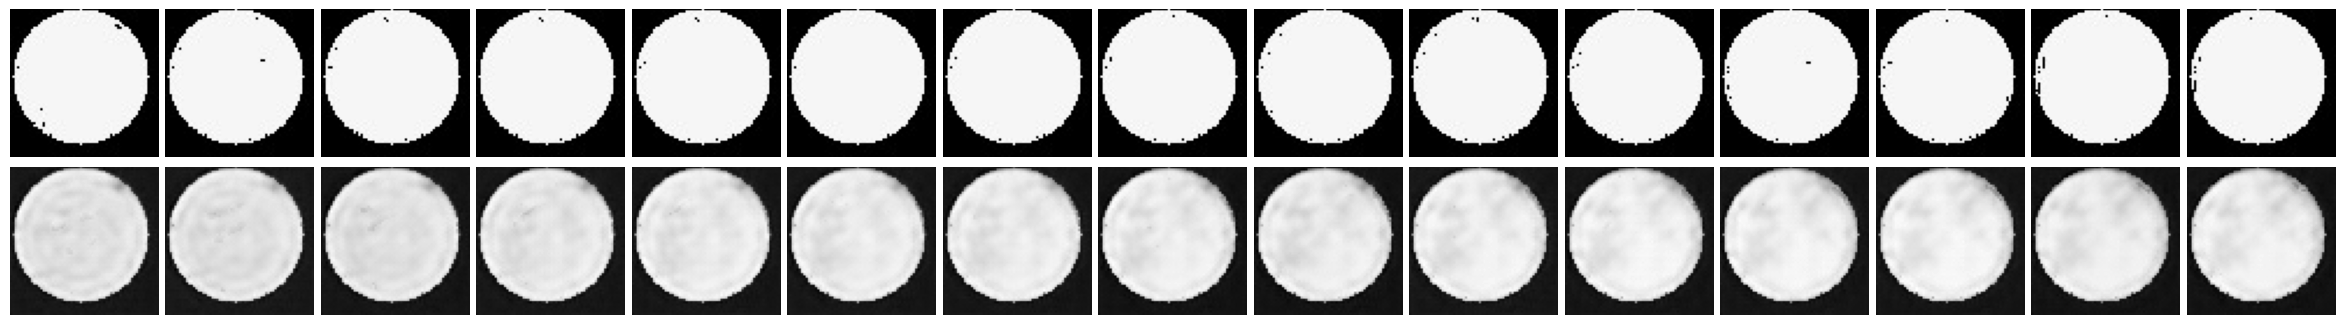

torch.Size([15, 1, 64, 64])


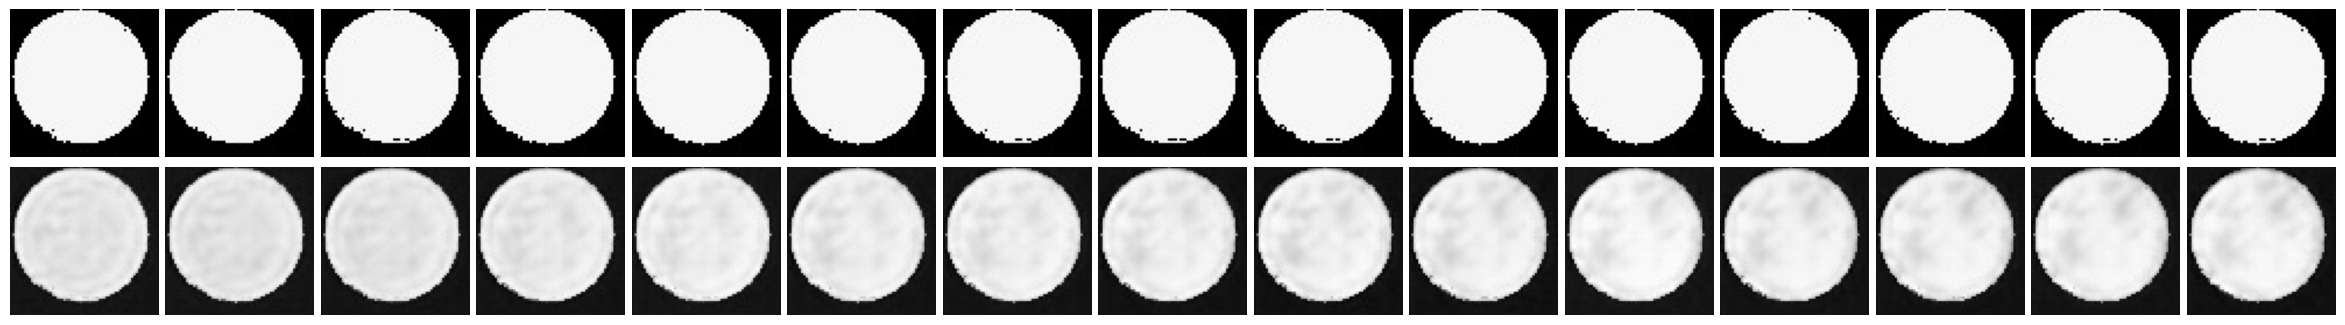

torch.Size([15, 1, 64, 64])


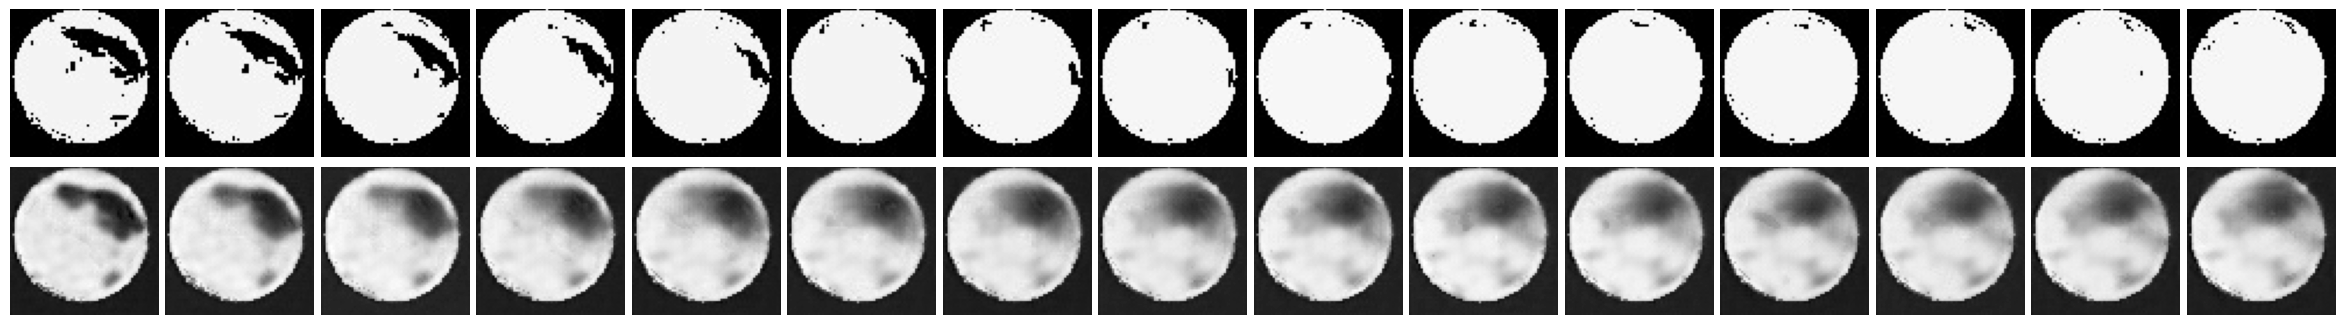

torch.Size([15, 1, 64, 64])


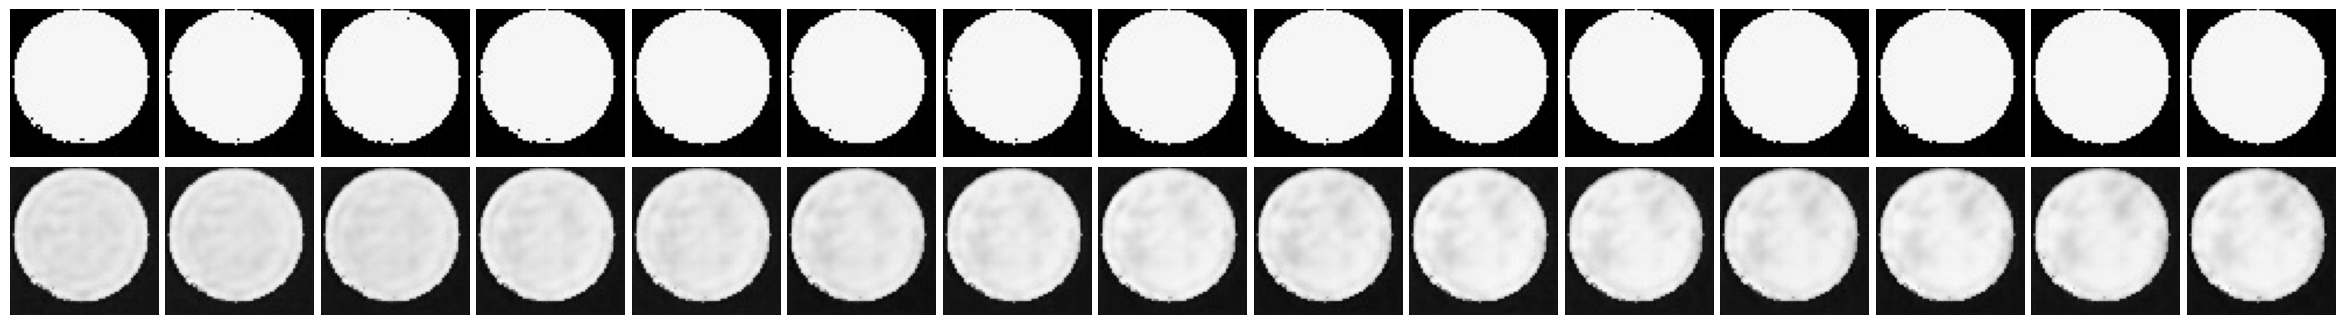

torch.Size([15, 1, 64, 64])


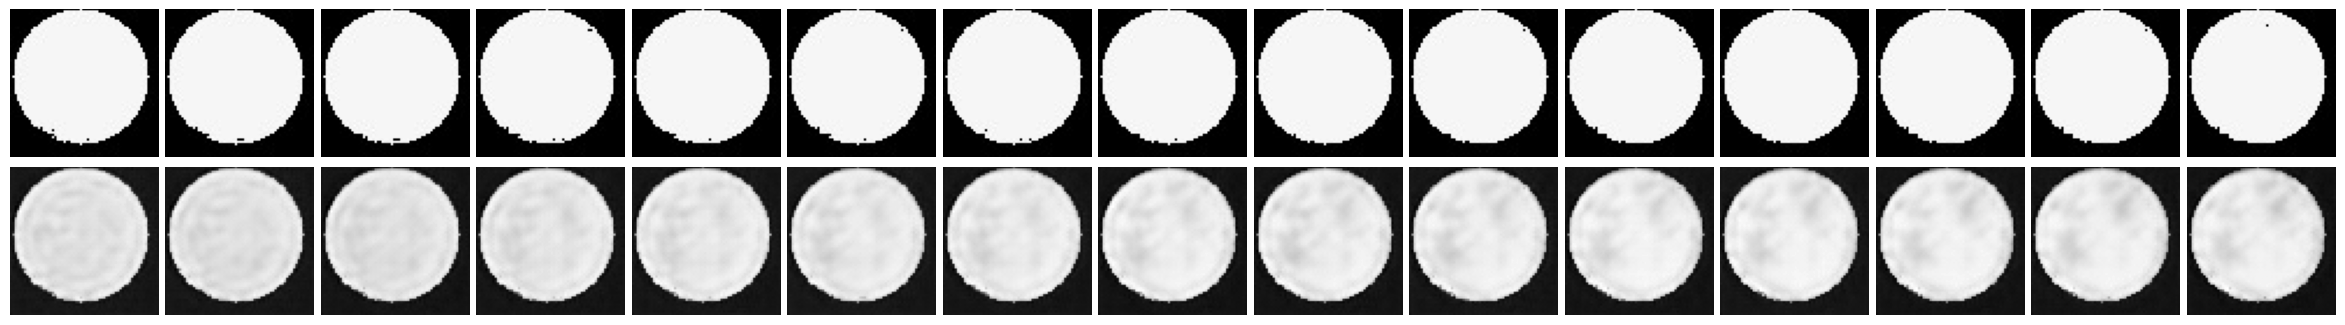

torch.Size([15, 1, 64, 64])


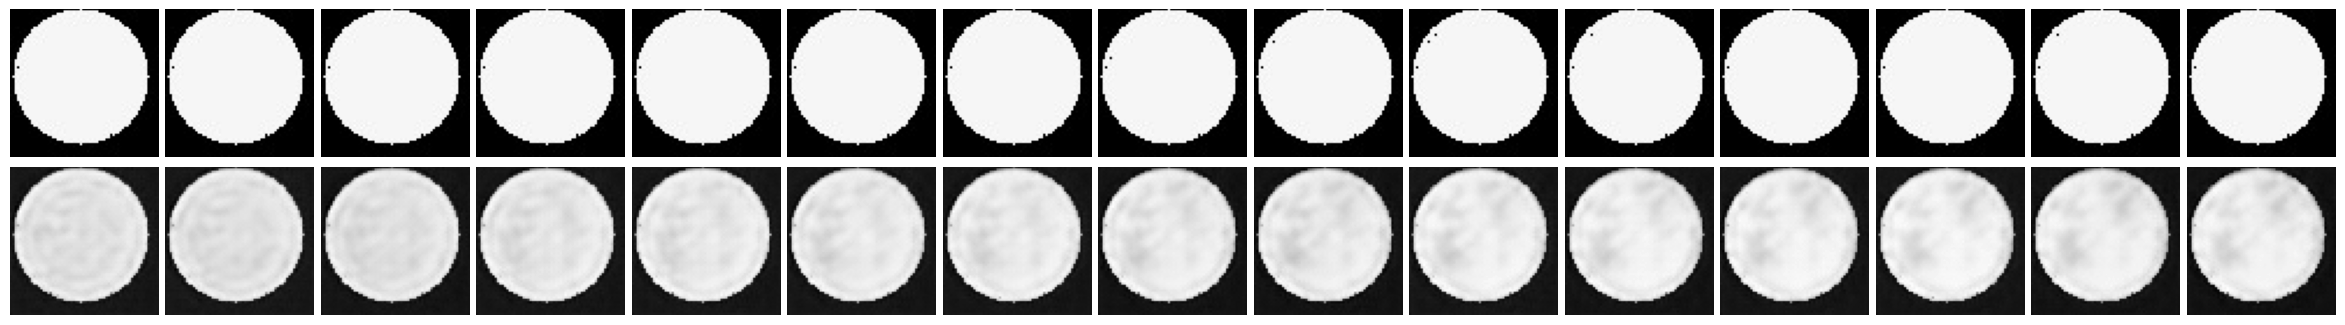

torch.Size([15, 1, 64, 64])


In [46]:
# Function to plot a row of images
def plot_images_row(images, row, axs):
    for i, img in enumerate(images):
        img_np = img.detach().cpu().numpy().transpose((1, 2, 0))
        axs[row, i].imshow(img_np,cmap="gray")
        axs[row, i].axis('off')  # Remove axis ticks and labels

# Create a figure to display the images
  # 2 rows, 15 columns
for images_pred,images_true in zip(images_p,images_t):
  fig, axs = plt.subplots(2, 15, figsize=(30, 4))
  # Plot true images in the first row
  plot_images_row(images_true, 0, axs)

  # Plot predicted images in the second row
  plot_images_row(images_pred, 1, axs)

  plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust the spacing between images
  plt.show()
  print(images_true.shape)
  
  